# 事例4：時間境界 τ に対する2次構造差（δ₂）の形状確認

## 目的

時間境界 τ を動かし、
before / after に分割した Production Quality Score の
2次構造差（分散差 δ₂）を算出することで、
τ に応じた δ₂ の形状を観測する。

## 分析の範囲（やること / やらないこと）

【やること】

- 時間境界 τ を複数候補として設定し、データを前後に分割する
- 各 τ について、前後の群を数値集合（NumPy配列）として定義する
- 全体平均で中心化した上で、前後の群の標本分散（ddof=1）を算出する
- 分散差 |var_before − var_after| を 2次構造差 δ₂ として定義する
- τ ごとに算出した δ₂ を τ に対応づけて整理し、系列的な挙動を確認する

【やらないこと】

- 原因の特定
- 因果関係の主張
- 予測モデルの構築
- 構造差の一般化（別データ・別指標への拡張）
- 結果の解釈・妥当性評価

## 目次

1. データの読み込みと分析対象の定義
2. τ 候補の生成
3. δ₂ 計算ロジックの適用
4. δ₂ 系列の可視化と形状確認

## 1. データの読み込みと分析対象の定義

本節では、分析に用いる生データを読み込み、
本事例における分析対象を定義する。
具体的には、時間分割に用いる Timestamp と、
分析対象の数値変数である Production Quality Score を扱う。

In [13]:
import sys
sys.path.append("src")

import pandas as pd
import numpy as np
from src.metrics import delta2
import matplotlib.pyplot as plt

df = pd.read_csv("data/raw/Manufacturing_dataset.csv")


## 2. τ 候補の生成

### 目的

δ₂(τ) の挙動を確認するため、
評価対象として回す τ の集合を定義・固定する。

### 前提

- τ はインデックス基準
- δ₂ の定義・内部構造は本セクションでは考慮しない
- Notebook は上から順に実行される構造を前提とする

### 探索空間の定義

- τ ∈ {1, …, n−1}
- 端点は before / after が空になるため除外
- 数学的健全性（標本分散の成立など）は後段で扱う

### 実装方針

- τ 候補は数字列として生成するのみ
- 実装モードを切り替え可能とする
  - `full`：全 τ
  - `sampled`：等間隔で最大100点（重複除去）
- サンプリングは近似手段であり、定義そのものではない

In [14]:
def generate_tau_candidates(n, mode, max_points):
    """
    τ候補生成関数
    n          : データ行数
    mode       : "full"（全τ） / "sampled"（等間隔で最大 max_points）
    max_points : sampled 時の最大点数
    """
    if n <= 1:
        return []

    # 母集合：1〜n-1
    tau_all = [x for x in range(1, n)]

    if mode == 'full':
        return tau_all

    if mode == 'sampled':
        if len(tau_all) <= max_points:
            return tau_all
        else:
            # 等間隔サンプリング（左寄り）
            s = max(1, len(tau_all) // max_points)
            return [tau_all[i*s] for i in range(max_points)]

    raise ValueError("mode must be 'full' or 'sampled'")

- ここから τ 生成関数を呼んで、tau_candidates を作る
- mode は full / sampled を切り替え可能
- 中身は確認するが、評価や判定は行わない


In [15]:
n = len(df)

candidates_full = generate_tau_candidates(n, mode="full", max_points=100)
candidates_sampled = generate_tau_candidates(n, mode="sampled", max_points=100)

## 3. δ₂ 計算ロジックの適用

### 目的

τ 候補に対して δ₂ を計算し、
τ と δ₂ の対応関係を整理する

### 前提

セクション2で tau_candidates が生成済み

δ₂ は事例3で定義済み・凍結

Notebook は上から順に実行される構造を前提

### 実装方針

τ の各値に対して δ₂ を適用する

計算結果は リストや配列に格納

健全性チェック（標本分散など）は各 τ に適用時に行う

評価・判定・可視化はまだ行わない

In [16]:
# df_small の準備
df_small = df[[
    "Timestamp",
    "Temperature (°C)",
    "Production Quality Score"
]].copy()

df_small["Timestamp"] = pd.to_datetime(df_small["Timestamp"], errors="coerce")

# δ₂ 適用用の関数（τはインデックス境界）
def tau_delta2(df, value_col, tau_candidates):
    results = []
    for tau in tau_candidates:
        # τ に従って before / after に分割（インデックス基準）
        before = df.iloc[:tau]
        after  = df.iloc[tau:]

        x_before = before[value_col].to_numpy(dtype=float)
        x_after  = after[value_col].to_numpy(dtype=float)

        # サイズ不足はスキップ
        if len(x_before) < 2 or len(x_after) < 2:
            continue

        # δ₂ 計算
        results.append((tau, delta2(x_before, x_after)))

    return results

# δ₂ 計算
results_full = tau_delta2(df_small, "Production Quality Score", candidates_full)
results_sampled = tau_delta2(df_small, "Production Quality Score", candidates_sampled)

## 4. τ 間の相対比較と可視化

本セクションでは、
セクション3で算出した δ₂ を用い、
τ の違いによる構造差の相対的な傾向を可視化する。

full / sampled の両データについて
τ–δ₂ 系列の振る舞いを確認し、
サンプリングによる形状の変化と安定性を観測する。

なお、本分析では
因果推論・最適化・変更理由の特定は行わない。

### 4-1：full の τ–δ₂ を可視化

セクション3で得られた results_full を用い、
τ に対する δ₂ の系列を可視化する。

τ–δ₂ の形状と変動の連続性に着目し、
値の大小や極値の解釈は行わない。

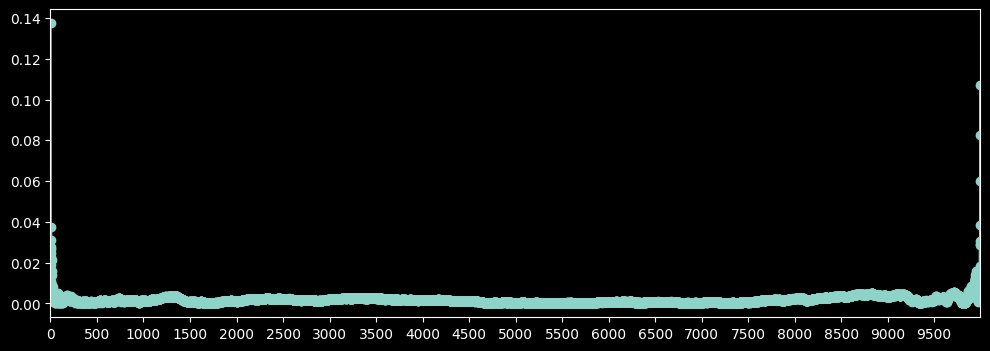

In [20]:
# 4-1 full

sorted_results_full = sorted(results_full, key=lambda x: x[0])

taus_f = []
delta_f = []

for t, d in sorted_results_full:
    taus_f.append(t)
    delta_f.append(d)

xmin = 0
xmax = max(taus_f)
ticks = list(range(0, xmax + 1, 500))

plt.figure(figsize=(12, 4))
plt.plot(taus_f, delta_f, marker="o")
plt.xlim(xmin, xmax)
plt.xticks(ticks)
plt.show()



- 観測結果（full）

τ が系列の端点に近づくにつれて δ₂ は増大し、
中央付近では δ₂ は小さく、比較的安定している。

これは before / after のサンプルサイズ不均衡に起因する
端点効果を反映した挙動と解釈できる。

### 4-2：sampled の τ–δ₂ を可視化

セクション3で得られた results_sampled を用い、
τ に対する δ₂ の系列を可視化する。

sampled は近似的な観測手段であるため、
full と比較せず、単体として形状の傾向のみを観測する。

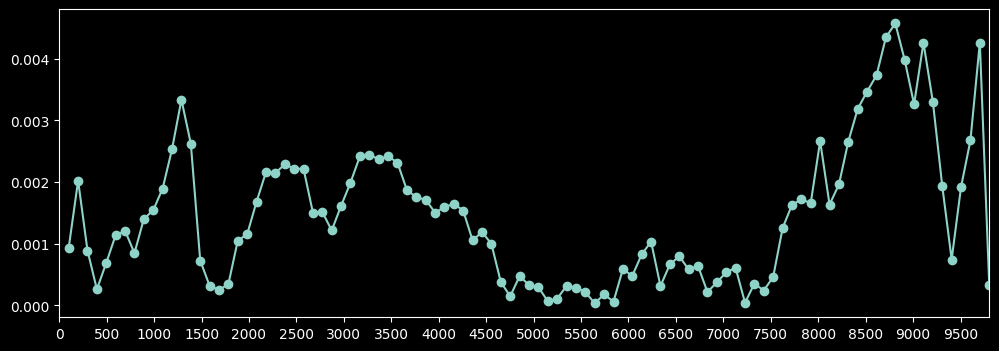

In [18]:
# 4-2 sampled

sorted_results_sampled = sorted(results_sampled, key=lambda x: x[0])

taus_s = []
delta_s = []

for t, d in sorted_results_sampled:
    taus_s.append(t)
    delta_s.append(d)

xmin = 0
xmax = max(taus_s)
ticks = list(range(0, xmax + 1, 500))

plt.figure(figsize=(12, 4))
plt.plot(taus_s, delta_s, marker="o")
plt.xlim(xmin, xmax)
plt.xticks(ticks)
plt.show()


#### 観測結果（sampled）

sampled による δ₂ の系列は、τ 全域で一様な挙動を示すわけではなく、
左右の端点と、性質の異なる中央の2区間に分けて整理できる。

- 左端（初期側）
τ が小さい範囲では δ₂ の変動幅が大きく、不安定な挙動が見られる。
before / after のサンプルサイズ不均衡による端点効果が強く現れており、
局所的なばらつきが顕著である。

- 中央前半
中央前半の区間では、δ₂ に比較的明確な起伏が観測される。
値は一定水準に収束せず、
構造的な変動を含む帯として現れている。

- 中央後半
中央後半では δ₂ は低水準で推移し、
変動も相対的に抑えられた準安定的な挙動を示す。

- 右端（終端側）
τ が大きい範囲では再び変動幅が拡大し、
左端と同様に端点付近特有の不安定性が顕在化している。

δ₂ の系列は、
端点では一貫して不安定であり、
中央では性質の異なる複数の挙動区間を含む形状を示している。

本分析は形状把握を目的としており、
区間間の比較評価や原因推定には踏み込まない


## 事例4：時間境界 τ に対する構造差 δ₂ の形状確認

本事例では、時間境界 τ を系列上で移動させたときに、
構造差指標 δ₂ がどのような形状を示すかを確認した。
原因推定や最適化、現実イベントの特定は目的としない。

### 実施内容

Timestamp に基づきデータを before / after に分割し、
各 τ について δ₂ を計算した。
サイズ不足となる τ は除外し、
τ と δ₂ の対応関係を保持した系列として整理した。

full データおよび sampled データの双方について、
δ₂ の系列を可視化し、形状の観測を行った。

### 観測結果

δ₂ の系列は τ 全域で一様な挙動を示すわけではなく、
端点付近と中央帯で性質の異なる挙動が観測された。

端点近傍では変動幅が大きく、不安定な挙動が一貫して見られた。
一方、中央帯では δ₂ は相対的に低水準で推移し、
比較的安定した挙動が観測された。

この中央帯内部の挙動については、
sampled データにおいて構造的な起伏を含む区間と
低水準で準安定的な区間が区別して観測された。

sampled による観測ではサンプリングに伴う揺れを含みつつも、
端点不安定性と中央帯の区間構造という
大局的な形状が確認された。

### 限界と位置づけ

本事例は δ₂ の形状把握を目的としており、
区間間の優劣評価や因果的解釈には踏み込まない。
特に端点付近ではデータ量低下の影響が大きく、
δ₂ の値そのものの解釈には注意を要する。

### まとめ

本事例により、
δ₂ は時間境界 τ に依存した非一様な形状を持ち、
端点不安定性と中央帯の区間構造を含むことが確認された。

本分析は、構造差指標の性質と限界を整理する位置づけとして完結する。
